# POSEIDON Retrievals with a Relative Offset

This is a slightly modified version of the 'basic retrieval' tutorial, but with an offset applied to the WFC3 data to show to to retrieve an offset.

In [1]:
from POSEIDON.core import create_star, create_planet
from POSEIDON.constants import R_Sun, R_J

#***** Define stellar properties *****#

R_s = 1.155*R_Sun     # Stellar radius (m)
T_s = 6071.0          # Stellar effective temperature (K)
Met_s = 0.0           # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.38        # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s)

#***** Define planet properties *****#

planet_name = 'WASP-999b'  # Planet name used for plots, output files etc.

R_p = 1.359*R_J     # Planetary radius (m)
g_p = 9.186         # Gravitational field of planet (m/s^2)
T_eq = 1400.0       # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, gravity = g_p, T_eq = T_eq)

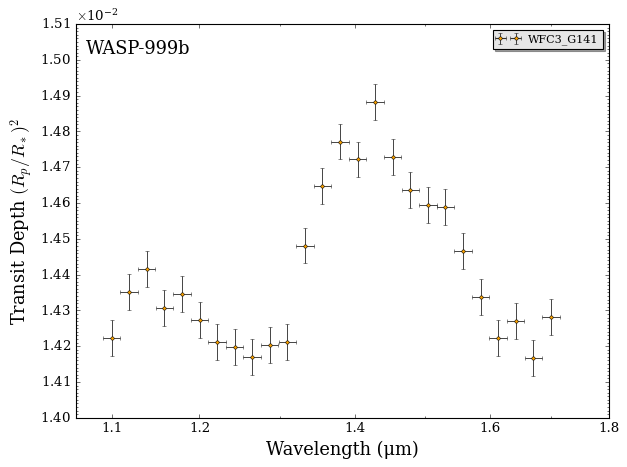

In [2]:
from POSEIDON.core import load_data, wl_grid_constant_R
from POSEIDON.visuals import plot_data

#***** Model wavelength grid *****#

wl_min = 0.4      # Minimum wavelength (um)
wl_max = 1.8      # Maximum wavelength (um)
R = 4000          # Spectral resolution of grid      

# We need to provide a model wavelength grid to initialise instrument properties
wl = wl_grid_constant_R(wl_min, wl_max, R)

#***** Specify data location and instruments  *****#

data_dir = '../../../POSEIDON/reference_data/observations/WASP-999b'  # Special directory for this tutorial
datasets = ['WASP-999b_WFC3_G141.dat']  # Found in reference_data/observations
instruments = ['WFC3_G141']             # Instruments corresponding to the data

# Load dataset, pre-load instrument PSF and transmission function
data = load_data(data_dir, datasets, instruments, wl)

# Plot our data
fig_data = plot_data(data, planet_name)

#### Write data file with offset applied

Let's add a 500 ppm offset to the WFC3 data for this test.

In [3]:
import numpy as np

ydata_offset = data['ydata'] + 500e-6    # We'll use a 500 ppm offset to the transit depth

out_name = data_dir + '/WASP-999b_WFC3_G141_OFFSET.dat'   # Name of new WFC3 data file

# Write output file
out_data = np.column_stack((data['wl_data'], data['half_bin'], ydata_offset, data['err_data']))
out_fmt = ['%.6f', '%.6f', '%.6e', '%.6e']
np.savetxt(out_name, out_data, delimiter = ' ', fmt = out_fmt)

When you read in a dataset that we suspect has an offset, you flag that dataset via an optional argument in the ``load_data`` function.

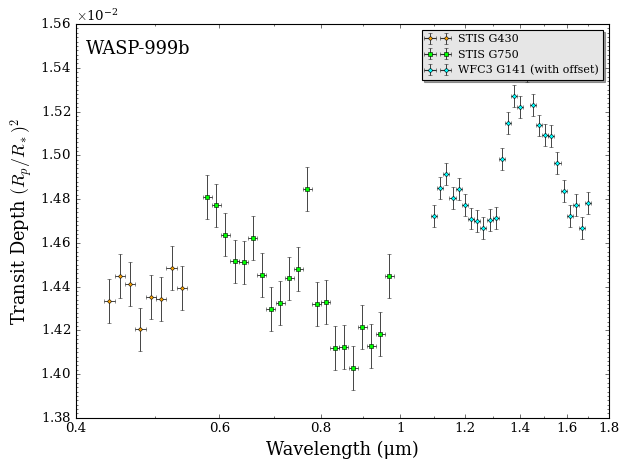

In [4]:
# Specify the STIS and new WFC3 Hubble data                
datasets = ['WASP-999b_STIS_G430.dat', 
            'WASP-999b_STIS_G750.dat', 
            'WASP-999b_WFC3_G141_OFFSET.dat']  
instruments = ['STIS_G430', 'STIS_G750', 'WFC3_G141']

# Load dataset, pre-load instrument PSF and transmission function
data = load_data(data_dir, datasets, instruments, wl, 
                 offset_datasets = ['WASP-999b_WFC3_G141_OFFSET.dat'])

# Plot our data
fig_data = plot_data(data, planet_name, data_labels = ['STIS G430', 'STIS G750', 'WFC3 G141 (with offset)'])

Yeah, that's a pretty big offset! 😮

### Configuring a Retrieval with a Free Offset

We'll define here the 'right' model I used to generate the simulated Hubble data, but also add a single free offset.

In [5]:
from POSEIDON.core import define_model

#***** Define model *****#

model_name = 'Retrieval_with_offset'  # Model name used for plots, output files etc.

bulk_species = ['H2', 'He']         # H2 + He comprises the bulk atmosphere
param_species = ['Na', 'K', 'H2O']

# Create the model object
model = define_model(model_name, bulk_species, param_species, 
                     PT_profile = 'isotherm', cloud_model = 'cloud-free',
                     offsets_applied = 'single_dataset')

# Check the free parameters defining this model
print("Free parameters: " + str(model['param_names']))

Free parameters: ['R_p_ref' 'T' 'log_Na' 'log_K' 'log_H2O' 'delta_rel']


For offsets, you could use a uniform prior (like below) or a Gaussian prior centred on zero with a large width (e.g. a standard deviation of 100 ppm). Since the true answer here is a large 500 ppm offset, we'll just use a uniform prior.

The unit used for relative offset priors in POSEIDON is parts per million.

In [6]:
from POSEIDON.core import set_priors

#***** Set priors for retrieval *****#

# Initialise prior type dictionary
prior_types = {}

# Specify whether priors are linear, Gaussian, etc.
prior_types['T'] = 'uniform'
prior_types['R_p_ref'] = 'uniform'
prior_types['log_H2O'] = 'uniform'
prior_types['delta_rel'] = 'uniform'

# Initialise prior range dictionary
prior_ranges = {}

# Specify prior ranges for each free parameter
prior_ranges['T'] = [400, 1600]
prior_ranges['R_p_ref'] = [0.85*R_p, 1.15*R_p]
prior_ranges['log_H2O'] = [-12, -1]
prior_ranges['delta_rel'] = [-1000, 1000]   # Offset units are in parts per million, so this is -1000 ppm to +1000 ppm

# Create prior object for retrieval
priors = set_priors(planet, star, model, data, prior_types, prior_ranges)

In [8]:
from POSEIDON.core import read_opacities
import numpy as np

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# Define fine temperature grid (K)
T_fine_min = 400     # Same as prior range for T
T_fine_max = 1600    # Same as prior range for T
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

# Pre-interpolate the opacities
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
Na done
K done
H2O done
Opacity pre-interpolation complete.


In [8]:
from POSEIDON.retrieval import run_retrieval

#***** Specify fixed atmospheric settings for retrieval *****#

# Atmospheric pressure grid
P_min = 1.0e-7    # 0.1 ubar
P_max = 100       # 100 bar
N_layers = 100    # 100 layers

# Let's space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure
P_ref = 10.0   # Retrieved R_p_ref parameter will be the radius at 10 bar

#***** Run atmospheric retrieval *****#

run_retrieval(planet, star, model, opac, data, priors, wl, P, P_ref, R = R, 
              spectrum_type = 'transmission', sampling_algorithm = 'MultiNest', 
              N_live = 400, verbose = True)


POSEIDON now running 'Retrieval_with_offset'
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    6
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.991189
Replacements:                                450
Total Samples:                               454
Nested Sampling ln(Z):            -122246.908671
Acceptance Rate:                        0.970874
Replacements:                                500
Total Samples:                               515
Nested Sampling ln(Z):             -86446.085163
Acceptance Rate:                        0.940171
Replacements:                                550
Total Samples:                               585
Nested Sampling ln(Z):             -64567.322046
Acceptance Rate:                        0.89153

### Plotting Retrieval Results

Corner plot time! Let's also overplot the true parameter values I used to make the data.

Generating corner plot ...


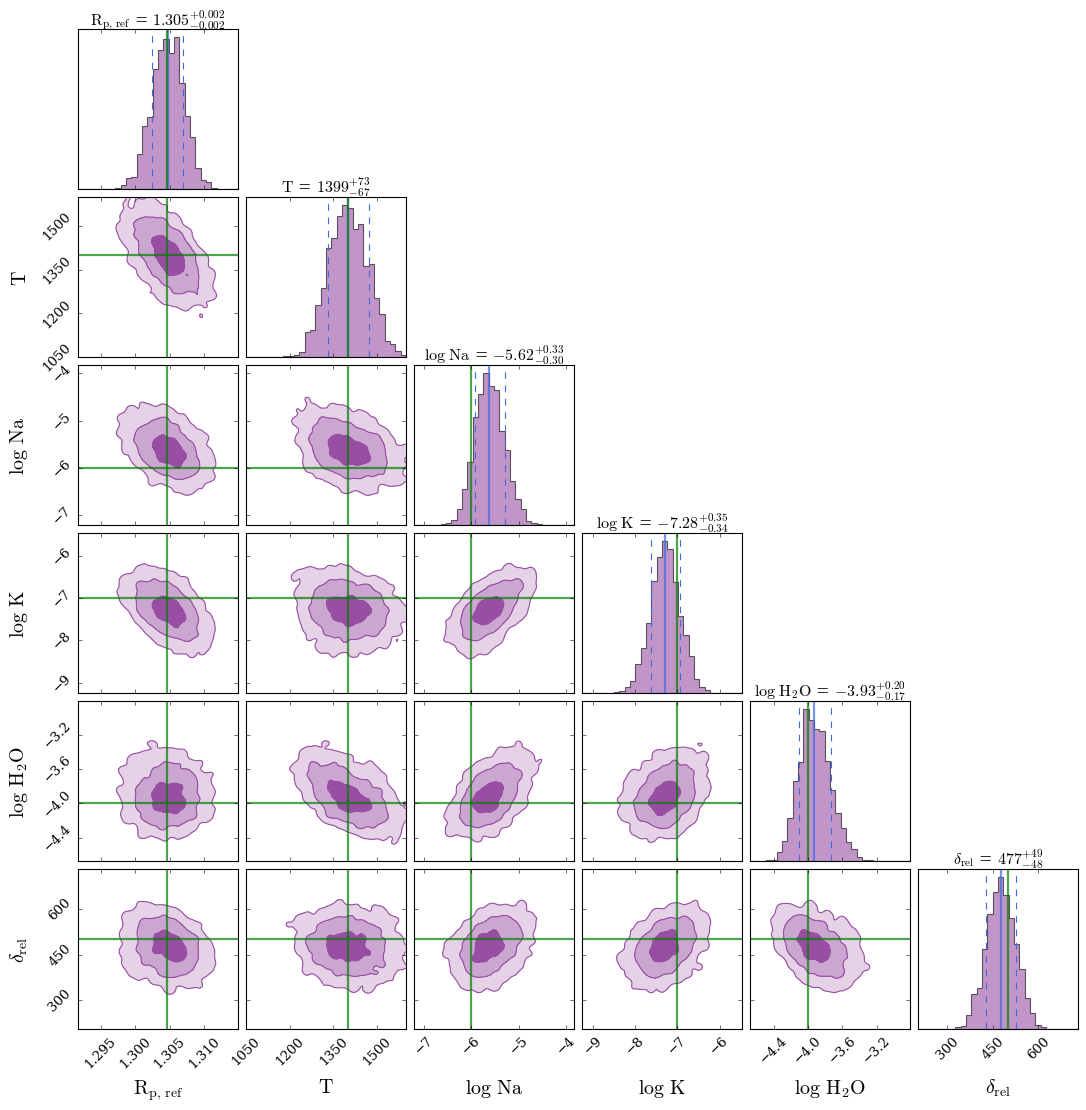

In [8]:
from POSEIDON.corner import generate_cornerplot

#***** Make corner plot *****#

fig_corner = generate_cornerplot(planet, model, 
                                 true_vals = [0.96*(R_p/R_J), 1400, -6.0, -7.0, -4.0, 500])   # The last parameter is the offset

Time to plot the retrieved spectrum.

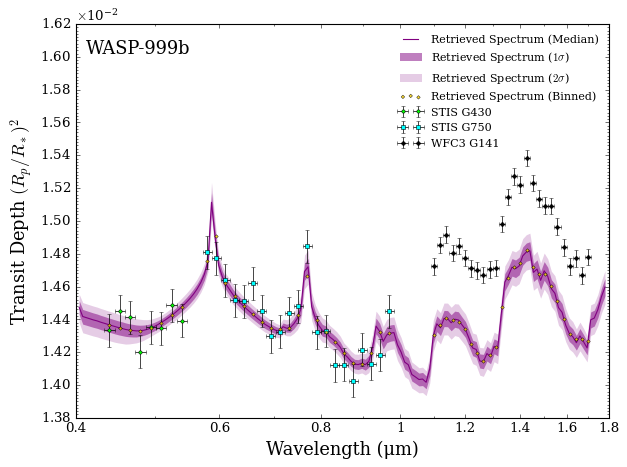

In [9]:
from POSEIDON.utility import read_retrieved_spectrum, plot_collection
from POSEIDON.visuals import plot_spectra_retrieved

#***** Plot retrieved transmission spectrum *****#

# Read retrieved spectrum confidence regions
wl, spec_low2, spec_low1, spec_median, \
spec_high1, spec_high2 = read_retrieved_spectrum(planet_name, model_name)

# Create composite spectra objects for plotting
spectra_median = plot_collection(spec_median, wl, collection = [])
spectra_low1 = plot_collection(spec_low1, wl, collection = []) 
spectra_low2 = plot_collection(spec_low2, wl, collection = []) 
spectra_high1 = plot_collection(spec_high1, wl, collection = []) 
spectra_high2 = plot_collection(spec_high2, wl, collection = [])

# Produce figure
fig_spec = plot_spectra_retrieved(spectra_median, spectra_low2, spectra_low1, 
                                  spectra_high1, spectra_high2, planet_name,
                                  data, R_to_bin = 100,
                                  data_labels = ['STIS G430', 'STIS G750', 'WFC3 G141'],
                                  data_colour_list = ['lime', 'cyan', 'black'])

As you can see, the WFC3 data shown in the retrieved spectra plot is just the raw data without the offset applied. So let's subtract the median retrieved offset from the WFC3 transit depths and remake the plot.

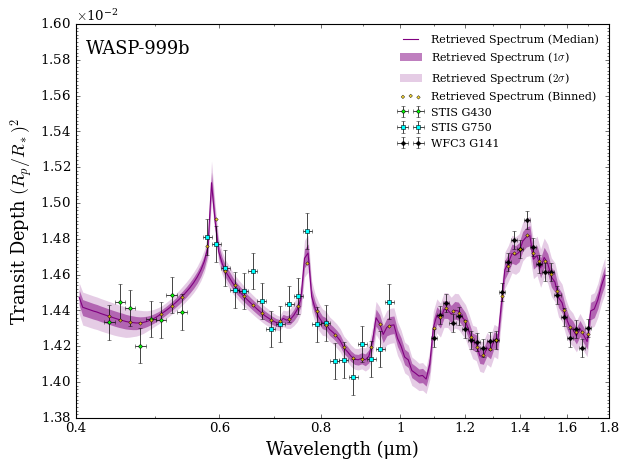

In [10]:
ydata = data['ydata']                 # Transit depths from the data files
offset_start = data['offset_start']   # Index where WFC3 data starts
offset_end = data['offset_end']       # Index where WFC3 data ends

# Apply median retrieved offset to the WFC3 data
ydata[offset_start:offset_end] -= 477e-6   # Subtract 477 ppm (from the corner plot above) to correct for the offset (we wouldn't know the 'true' offset is 500 ppm)

# Remake the retrieved spectrum plot with the offset correction applied
fig_spec = plot_spectra_retrieved(spectra_median, spectra_low2, spectra_low1, 
                                  spectra_high1, spectra_high2, planet_name,
                                  data, R_to_bin = 100,
                                  data_labels = ['STIS G430', 'STIS G750', 'WFC3 G141'],
                                  data_colour_list = ['lime', 'cyan', 'black'])

🎉🎉🎉